In [ ]:
!nvidia-smi

Tue Aug 31 08:44:19 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#dataset 
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 0), reused 0 (delta 0), pack-reused 30
Unpacking objects: 100% (33/33), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [ ]:
!ls /content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [ ]:
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"


In [ ]:
import os
filename = [data_dir + filename for filename in os.listdir(data_dir)]

In [ ]:
filename

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

In [ ]:
def get_lines(filename):
  ''' 
  rads file name and displays a list of strings '''
  with open(filename,'r') as f:
    return f.readlines()

In [ ]:
train_lines = get_lines(data_dir+"train.txt")
len(train_lines)

210040

In [ ]:
  def preprocess_text_with_line_numbers(filename):
    '''
    returs a list of dictionaries target label text of sentences number of lines"
    '''

    input_lines = get_lines(filename)
    abstract_lines = ""
    abstract_samples = []

    for line in input_lines:
      if line.startswith("###"):
        abstract_id = line
        abstract_lines = ""
      elif line.isspace():
        abstract_line_split = abstract_lines.splitlines()

        for abstract_line_mumber, abstract_line in enumerate(abstract_line_split):
          line_data = {}
          target_text_split = abstract_line.split("\t")
          line_data["target"]= target_text_split[0]
          line_data['text'] = target_text_split[1].lower()
          line_data['line_number'] = abstract_line_mumber
          line_data["total_lines"] = len(abstract_line_split) - 1
          abstract_samples.append(line_data)
      else:
          abstract_lines += line
    return abstract_samples




In [ ]:
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")

val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt")

test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")



In [ ]:
len(train_samples), len(val_samples), len(test_samples)

(180040, 30212, 30135)

In [ ]:
import pandas as pd

train_df = pd.DataFrame(train_samples)

val_df = pd.DataFrame(val_samples)

test_df = pd.DataFrame(test_samples)

In [ ]:
train_df

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
...,...,...,...,...
180035,RESULTS,for the absolute change in percent atheroma vo...,7,11
180036,RESULTS,"for pav , a significantly greater percentage o...",8,11
180037,RESULTS,both strategies had acceptable side effect pro...,9,11
180038,CONCLUSIONS,"compared with standard statin monotherapy , th...",10,11


In [ ]:
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

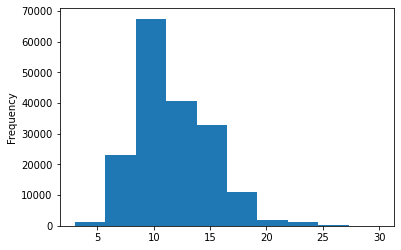

In [ ]:
train_df.total_lines.plot.hist()

In [ ]:
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df['text'].tolist()
len(train_sentences),len(val_sentences),len(test_sentences)

(180040, 30212, 30135)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

In [ ]:
import tensorflow as tf
# labele encode labels =
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())


In [ ]:
#get class names 
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes,class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

In [ ]:
##model_0 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [ ]:
model_0 = Pipeline([
          ('tfidf',TfidfVectorizer()),
          ('clf',MultinomialNB())          
])

model_0.fit(X=train_sentences,
            y=train_labels_encoded)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [ ]:
model_0.score(X=val_sentences,
                 y=val_labels_encoded)

0.7218323844829869

In [ ]:
baseline_preds = model_0.predict(val_sentences)



In [ ]:
!wget https://raw.githubusercontent.com/Balagopal-datascientist/cnn_tensorflow_food/master/helper_functions.py

--2021-08-31 08:44:41--  https://raw.githubusercontent.com/Balagopal-datascientist/cnn_tensorflow_food/master/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-08-31 08:44:42 (113 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import calculate_results 


In [ ]:
baseline_results = calculate_results(val_labels_encoded,baseline_preds)

In [ ]:
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

In [ ]:
import numpy as np 
import tensorflow as tf
from tensorflow.keras import layers


In [ ]:
sent_lens = [len(sentence.split()) for sentence in train_sentences]

In [ ]:
avg_sent_lens = np.mean(sent_lens)

avg_sent_lens

26.338269273494777

(array([4.2075e+04, 8.3771e+04, 3.6877e+04, 1.0945e+04, 3.9310e+03,
        1.4450e+03, 5.6000e+02, 2.2600e+02, 1.0100e+02, 4.5000e+01,
        2.0000e+01, 1.2000e+01, 9.0000e+00, 1.0000e+01, 6.0000e+00,
        2.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  1.  ,  15.75,  30.5 ,  45.25,  60.  ,  74.75,  89.5 , 104.25,
        119.  , 133.75, 148.5 , 163.25, 178.  , 192.75, 207.5 , 222.25,
        237.  , 251.75, 266.5 , 281.25, 296.  ]),
 <a list of 20 Patch objects>)

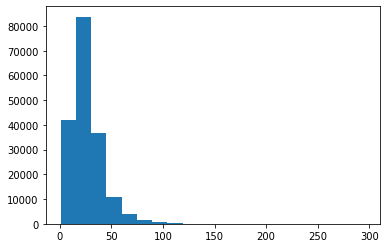

In [ ]:
import matplotlib.pyplot as plt 
plt.hist(sent_lens , bins = 20)

In [ ]:
 output_seq_lens = int(np.percentile(sent_lens,95))

In [ ]:
 output_seq_lens

55

In [ ]:
max_tokens= 68000

from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [ ]:
text_vectorizer = TextVectorization(max_tokens= max_tokens, output_sequence_length= output_seq_lens)

In [ ]:
text_vectorizer.adapt(train_sentences)

In [ ]:
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text:\n{text_vectorizer([target_sentence])}")

Text:
among patients infected with human immunodeficiency virus ( hiv ) , visceral adiposity is associated with metabolic dysregulation and ectopic fat accumulation .

Length of text: 23

Vectorized text:
[[  116    12  2618     7   631  4777  1308   500  3428  4844    20    81
      7   671 11220     3  6540   590  4399     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [ ]:
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocabulary: {len(rct_20k_text_vocab)}"), 
print(f"Most common words in the vocabulary: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocabulary: {rct_20k_text_vocab[-5:]}")

Number of words in vocabulary: 64841
Most common words in the vocabulary: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocabulary: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [ ]:
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab),output_dim=128,
                               mask_zero = True,
                               name="token_embeding")

In [ ]:
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
among patients infected with human immunodeficiency virus ( hiv ) , visceral adiposity is associated with metabolic dysregulation and ectopic fat accumulation .

Sentence after vectorization (before embedding):
[[  116    12  2618     7   631  4777  1308   500  3428  4844    20    81
      7   671 11220     3  6540   590  4399     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
[[[ 0.04387641  0.03125136  0.04899564 ...  0.00227563 -0.02998794
    0.02504453]
  [ 0.03512115 -0.01679635  0.01300291 ... -0.03708451  0.0190697
   -0.00664411]
  [-0.00314032  0.01071676  0.03301207 ... -0.03823305 -0.02397422
    0.04498968]
  ...
  [ 0.00875616 -0.04143622 -0.027001   ... -0.03635861  0.02624161
   -0.03208002]
  [ 0.00875616 -0.04143622 -0.027001   ... -0.036358

In [ ]:
#making sure data lodes fast as possible 
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences,train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences,val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences,test_labels_one_hot))

In [ ]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

In [ ]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings= token_embed(text_vectors)
x = layers.Conv1D(64, kernel_size=5, padding= "same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs= layers.Dense(num_classes, activation = "softmax")(x)
model_1 = tf.keras.Model(inputs,outputs)

In [ ]:
model_1.compile(loss= "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
model_1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 55)                0         
_________________________________________________________________
token_embeding (Embedding)   (None, 55, 128)           8299648   
_________________________________________________________________
conv1d (Conv1D)              (None, 55, 64)            41024     
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 5)                 325       
Total params: 8,340,997
Trainable params: 8,340,997
Non-trainable params: 0
___________________________________________________

In [ ]:
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch= len(train_dataset),
                              epochs=3,
                              validation_data=valid_dataset,
                              )

Epoch 1/3
5627/5627 [==============================] - 58s 7ms/step - loss: 0.6156 - accuracy: 0.7765 - val_loss: 0.5341 - val_accuracy: 0.8100
Epoch 2/3
5627/5627 [==============================] - 42s 7ms/step - loss: 0.4517 - accuracy: 0.8421 - val_loss: 0.5332 - val_accuracy: 0.8112
Epoch 3/3
5627/5627 [==============================] - 42s 7ms/step - loss: 0.3714 - accuracy: 0.8727 - val_loss: 0.5664 - val_accuracy: 0.8070


In [ ]:
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs

array([[7.0602149e-01, 8.0392621e-03, 1.9052057e-01, 6.6968143e-02,
        2.8450469e-02],
       [6.0248560e-01, 6.5076649e-02, 2.9369507e-03, 3.1957692e-01,
        9.9239480e-03],
       [1.3189730e-01, 5.8730049e-03, 1.3365400e-03, 8.6082798e-01,
        6.5211687e-05],
       ...,
       [3.1887595e-07, 4.6097307e-06, 1.9975330e-03, 1.9150472e-07,
        9.9799734e-01],
       [1.2207389e-01, 5.8325315e-01, 1.2671638e-01, 3.6664333e-02,
        1.3129228e-01],
       [2.1901641e-03, 9.9643952e-01, 1.2654873e-03, 2.8845208e-05,
        7.5964177e-05]], dtype=float32)

In [ ]:
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [ ]:
model_1_results = calculate_results(val_labels_encoded,model_1_preds)

In [ ]:
model_1_results 

{'accuracy': 80.6997219647822,
 'f1': 0.804461668434619,
 'precision': 0.804534621193841,
 'recall': 0.806997219647822}

In [ ]:
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

In [ ]:
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [ ]:
random_training_sentence = random.choice(train_sentences)
print(f"Random training sentence:\n{random_training_sentence}\n")
use_embedded_sentence = tf_hub_embedding_layer([random_training_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]} (truncated output)...\n")
print(f"Length of sentence embedding:\n{len(use_embedded_sentence[0])}")

Random training sentence:
adverse effects of butylscopolamine were also examined .

Sentence after embedding:
[ 0.03315733  0.0691107   0.02723707 -0.08859326  0.00611466 -0.01163161
  0.00891631 -0.05916582 -0.05721756  0.00766919  0.05607829  0.03723609
  0.05584436  0.01623886 -0.00878981 -0.00669697 -0.06544879 -0.05945188
  0.00294039 -0.01082574 -0.03529656  0.07339434 -0.05624013 -0.00497474
  0.05018377 -0.04780894  0.02498235  0.0417406   0.05991865  0.09029753] (truncated output)...

Length of sentence embedding:
512


In [ ]:
inputs = layers.Input(shape=[], dtype=tf.string)
token_embeddings= tf_hub_embedding_layer(inputs)
x = layers.Dense(128,activation="relu")(token_embeddings)
#x = layers.Dense(128,activation="relu")(x)
#x = layers.Dense(128,activation="relu")(x)
outputs= layers.Dense(num_classes, activation = "softmax")(x)
model_2 = tf.keras.Model(inputs,outputs)

In [ ]:
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None,)]                 0         
_________________________________________________________________
universal_sentence_encoder ( (None, 512)               256797824 
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 645       
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
history_model_2 = model_2.fit(train_dataset,
                              steps_per_epoch= len(train_dataset),
                              epochs=3,
                              validation_data=valid_dataset,
                              )

Epoch 1/3
5627/5627 [==============================] - 56s 10ms/step - loss: 0.7304 - accuracy: 0.7211 - val_loss: 0.6574 - val_accuracy: 0.7494
Epoch 2/3
5627/5627 [==============================] - 54s 10ms/step - loss: 0.6357 - accuracy: 0.7588 - val_loss: 0.6227 - val_accuracy: 0.7619
Epoch 3/3
5627/5627 [==============================] - 55s 10ms/step - loss: 0.6016 - accuracy: 0.7723 - val_loss: 0.6076 - val_accuracy: 0.7677


In [ ]:
model_2_pred_probs = model_2.predict(valid_dataset)

In [ ]:
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 0, ..., 4, 4, 1])>

In [ ]:
model_2_results = calculate_results(val_labels_encoded,model_2_preds)

In [ ]:
model_2_results

{'accuracy': 76.7675095988349,
 'f1': 0.763692363255805,
 'precision': 0.7657611898348876,
 'recall': 0.767675095988349}

In [ ]:
def split_chars(text):
  return " ".join(list(text))

split_chars(random_training_sentence)

'a d v e r s e   e f f e c t s   o f   b u t y l s c o p o l a m i n e   w e r e   a l s o   e x a m i n e d   .'

In [ ]:
train_chars = [split_chars(sentence) for sentence in train_sentences]

val_chars = [split_chars(sentence) for sentence in val_sentences] 

test_chars = [split_chars(sentence) for sentence in test_sentences]



In [ ]:
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

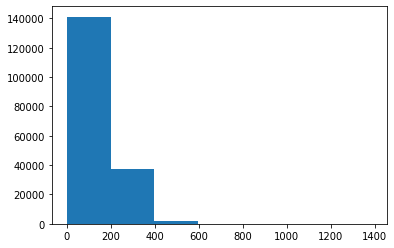

In [ ]:
import matplotlib.pyplot as plt

plt.hist(char_lens, bins=7);


In [ ]:
output_seq_char_len = int(np.percentile(char_lens,95))
output_seq_char_len

290

In [ ]:
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
NUM_CHAR_TOKENS = len(alphabet) +2
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,  
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")
char_vectorizer.adapt(train_chars)

In [ ]:
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [ ]:
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
t h o s e   t r e a t e d   w i t h   v e n l a f a x i n e   +   b r i g h t   l i g h t   t h e r a p y   e v i d e n c e d   s i g n i f i c a n t l y   l o w e r   h d r s   d e p r e s s i o n   s c o r e s   (   p   <   @   )   a s   w e l l   a s   b d i   s c o r e s   (   p   <   @   )   a n d   p o m s   n e g a t i v e   m o o d   s t a t e s   s c o r e s   (   d e p r e s s i o n - d e j e c t i o n   ,   t e n s i o n - a n x i e t y   ,   a n g e r - h o s t i l i t y   ,   f a t i g u e - i n e r t i a   ,   a n d   c o n f u s i o n - b e w i l d e r m e n t   s u b s c a l e s   ;   a l l   p   <   @   )   a f t e r   t h e   s e c o n d   w e e k   .

Length of chars: 282

Vectorized chars:
[[ 3 13  7  9  2  3  8  2  5  3  2 10 20  4  3 13 21  2  6 12  5 17  5 24
   4  6  2 22  8  4 18 13  3 12  4 18 13  3  3 13  2  8  5 14 19  2 21  4
  10  2  6 11  2 10  9  4 18  6  4 17  4 11  5  6  3 12 19 12  7 20  2  8
  13 10  8  9 10  2 14  8  2  9  9  4  7  6

In [ ]:
 char_embed = layers.Embedding(input_dim=NUM_CHAR_TOKENS,
                               output_dim = 25,
                               mask_zero = False,
                               name="char_embed")

In [ ]:
print(f"Charified text (before vectorization and embedding):\n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
t h o s e   t r e a t e d   w i t h   v e n l a f a x i n e   +   b r i g h t   l i g h t   t h e r a p y   e v i d e n c e d   s i g n i f i c a n t l y   l o w e r   h d r s   d e p r e s s i o n   s c o r e s   (   p   <   @   )   a s   w e l l   a s   b d i   s c o r e s   (   p   <   @   )   a n d   p o m s   n e g a t i v e   m o o d   s t a t e s   s c o r e s   (   d e p r e s s i o n - d e j e c t i o n   ,   t e n s i o n - a n x i e t y   ,   a n g e r - h o s t i l i t y   ,   f a t i g u e - i n e r t i a   ,   a n d   c o n f u s i o n - b e w i l d e r m e n t   s u b s c a l e s   ;   a l l   p   <   @   )   a f t e r   t h e   s e c o n d   w e e k   .

Embedded chars (after vectorization and embedding):
[[[ 0.00521551  0.04646755 -0.01356517 ... -0.02434967  0.03166801
   -0.03707717]
  [-0.00809971 -0.04561546 -0.02332687 ... -0.0376633   0.04679913
   -0.02983539]
  [ 0.03031936  0.00753226 -0.01938038 ... -0.0086

In [ ]:
inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size = 5, padding = "same",
                  activation = 'relu')(char_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation = "softmax")(x)
model_3 = tf.keras.Model(inputs = inputs,outputs = outputs, name = "model_3_convo1d")

In [ ]:
model_3.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [ ]:
model_3.summary()

Model: "model_3_convo1d"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
char_vectorizer (TextVectori (None, 290)               0         
_________________________________________________________________
char_embed (Embedding)       (None, 290, 25)           1750      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 290, 64)           8064      
_________________________________________________________________
global_average_pooling1d_1 ( (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 325       
Total params: 10,139
Trainable params: 10,139
Non-trainable params: 0
_______________________________________________

In [ ]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars,train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_char_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

In [ ]:
history_model_3 = model_3.fit(train_char_dataset,
                              steps_per_epoch= len(train_char_dataset),
                              epochs=3,
                              validation_data=val_char_dataset,
                              )

Epoch 1/3
5627/5627 [==============================] - 24s 4ms/step - loss: 1.3058 - accuracy: 0.4531 - val_loss: 1.2282 - val_accuracy: 0.4973
Epoch 2/3
5627/5627 [==============================] - 24s 4ms/step - loss: 1.2015 - accuracy: 0.5078 - val_loss: 1.1577 - val_accuracy: 0.5294
Epoch 3/3
5627/5627 [==============================] - 24s 4ms/step - loss: 1.1313 - accuracy: 0.5409 - val_loss: 1.0863 - val_accuracy: 0.5586


In [ ]:
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

array([[0.22652344, 0.24866374, 0.27059796, 0.14138994, 0.11282491],
       [0.14610961, 0.22578816, 0.2236123 , 0.06515157, 0.33933833],
       [0.16963184, 0.21333587, 0.3137678 , 0.2305648 , 0.0726997 ],
       ...,
       [0.01879104, 0.04835783, 0.19366248, 0.0081669 , 0.73102176],
       [0.0610321 , 0.15628831, 0.36871243, 0.04706138, 0.36690578],
       [0.2894427 , 0.23933539, 0.24625175, 0.07919124, 0.14577897]],
      dtype=float32)

In [ ]:
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([2, 4, 2, ..., 4, 2, 0])>

In [ ]:
model_3_results = calculate_results(y_true=val_labels_encoded,
                                        y_pred=model_3_preds)
model_3_results

{'accuracy': 55.85528928902422,
 'f1': 0.5277557351115421,
 'precision': 0.5292654132407885,
 'recall': 0.5585528928902422}

In [ ]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings) # bi-LSTM shown in Figure 1 of https://arxiv.org/pdf/1612.05251.pdf
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output, 
                                                                  char_model.output])

# 4. Create output layers - addition of dropout discussed in 4.2 of https://arxiv.org/pdf/1612.05251.pdf
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation="relu")(combined_dropout) # slightly different to Figure 1 due to different shapes of token/char embedding layers
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

In [ ]:
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
token_input (InputLayer)        [(None,)]            0                                            
__________________________________________________________________________________________________
char_vectorizer (TextVectorizat (None, 290)          0           char_input[0][0]                 
__________________________________________________________________________________________________
universal_sentence_encoder (Ker (None, 512)          256797824   token_input[0][0]                
__________________________________________________________________

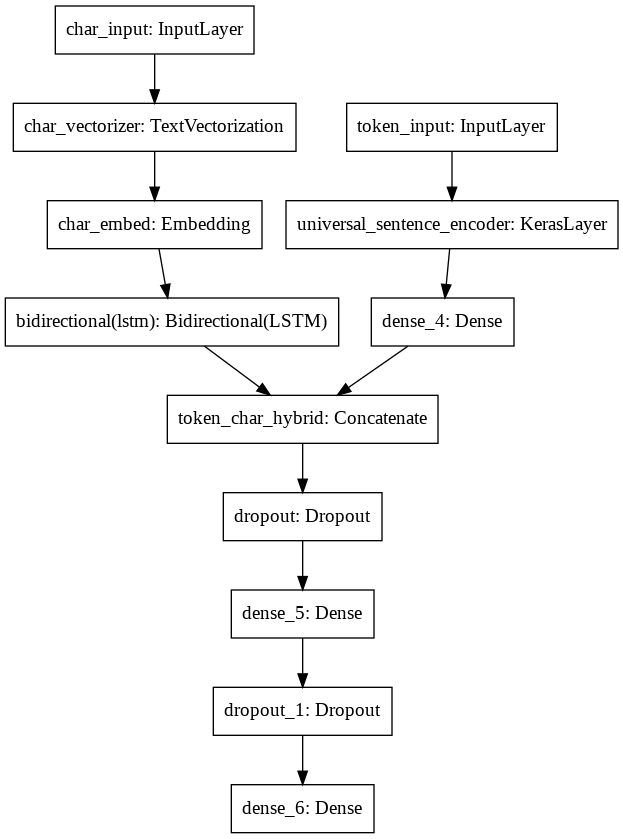

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_4)

In [ ]:
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))

train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)

train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels))

train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 

val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)



In [ ]:
model_4_history = model_4.fit(train_char_token_dataset, 
                              steps_per_epoch= len(train_char_token_dataset),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps= len(val_char_token_dataset))

Epoch 1/3
5627/5627 [==============================] - 154s 27ms/step - loss: 0.7544 - accuracy: 0.7113 - val_loss: 0.6252 - val_accuracy: 0.7619
Epoch 2/3
5627/5627 [==============================] - 150s 27ms/step - loss: 0.6729 - accuracy: 0.7464 - val_loss: 0.5970 - val_accuracy: 0.7730
Epoch 3/3
5627/5627 [==============================] - 150s 27ms/step - loss: 0.6494 - accuracy: 0.7562 - val_loss: 0.5851 - val_accuracy: 0.7768


In [ ]:
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

array([[5.0800598e-01, 3.2433653e-01, 1.4315423e-03, 1.6039185e-01,
        5.8340682e-03],
       [4.5283964e-01, 4.0345639e-01, 3.0064483e-03, 1.3875511e-01,
        1.9424006e-03],
       [5.3212976e-01, 8.3870348e-04, 1.5562727e-02, 4.5072493e-01,
        7.4388459e-04],
       ...,
       [2.2282222e-05, 2.0293272e-04, 5.2169207e-03, 4.7918070e-06,
        9.9455309e-01],
       [1.3167985e-02, 8.5242733e-02, 7.8405663e-02, 3.4594976e-03,
        8.1972408e-01],
       [2.3312880e-02, 9.6969777e-01, 4.9146269e-03, 3.3082819e-04,
        1.7439066e-03]], dtype=float32)

In [ ]:
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 0, ..., 4, 4, 1])>

In [ ]:
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 77.68436382894214,
 'f1': 0.7722690419465797,
 'precision': 0.7757190842390332,
 'recall': 0.7768436382894214}

In [ ]:
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

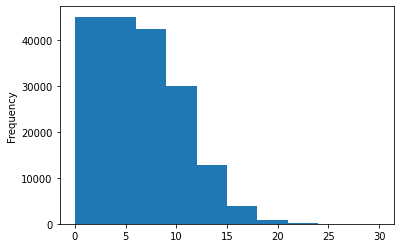

In [ ]:
train_df.line_number.plot.hist()
  

In [ ]:
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

In [ ]:
train_df["total_lines"].value_counts()


11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

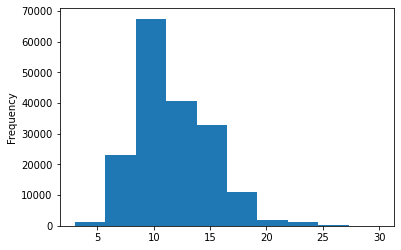

In [ ]:
train_df.total_lines.plot.hist();

In [ ]:
np.percentile(train_df.total_lines,98)

20.0

In [ ]:
train_total_lins_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(),depth=20)

val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)


In [ ]:
# token_inputs 
token_inputs = layers.Input(shape=[], dtype = "string", name = "token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128,activation = "relu")(token_embeddings)
token_model = tf.keras.Model(inputs = token_inputs, outputs = token_embeddings)


#char_inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs = char_inputs, outputs = char_bi_lstm)

#line number inputs 
line_number_inputs = layers.Input(shape=(15,), dtype=tf.int32, name = "line_numbr_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)
#Total lines inputs
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.int32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

#combineing char and token embeddings 
combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output,
                                                                              char_model.output])
z = layers.Dense(256, activation = "relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

#combine positional level embeddings with ombined tokens 
z = layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output,
                                                                total_line_model.output,
                                                                z])

#output_layer
output_layer = layers.Dense(5, activation = "softmax",
                            name= "output_layer")(z)

model_5 = tf.keras.Model(inputs=[line_number_model.input,total_line_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs = output_layer)

In [ ]:
model_5.summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_inputs (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
char_vectorizer (TextVectorizat (None, 290)          0           char_inputs[0][0]                
__________________________________________________________________________________________________
token_inputs (InputLayer)       [(None,)]            0                                            
__________________________________________________________________________________________________
char_embed (Embedding)          (None, 290, 25)      1750        char_vectorizer[3][0]            
___________________________________________________________________________________________

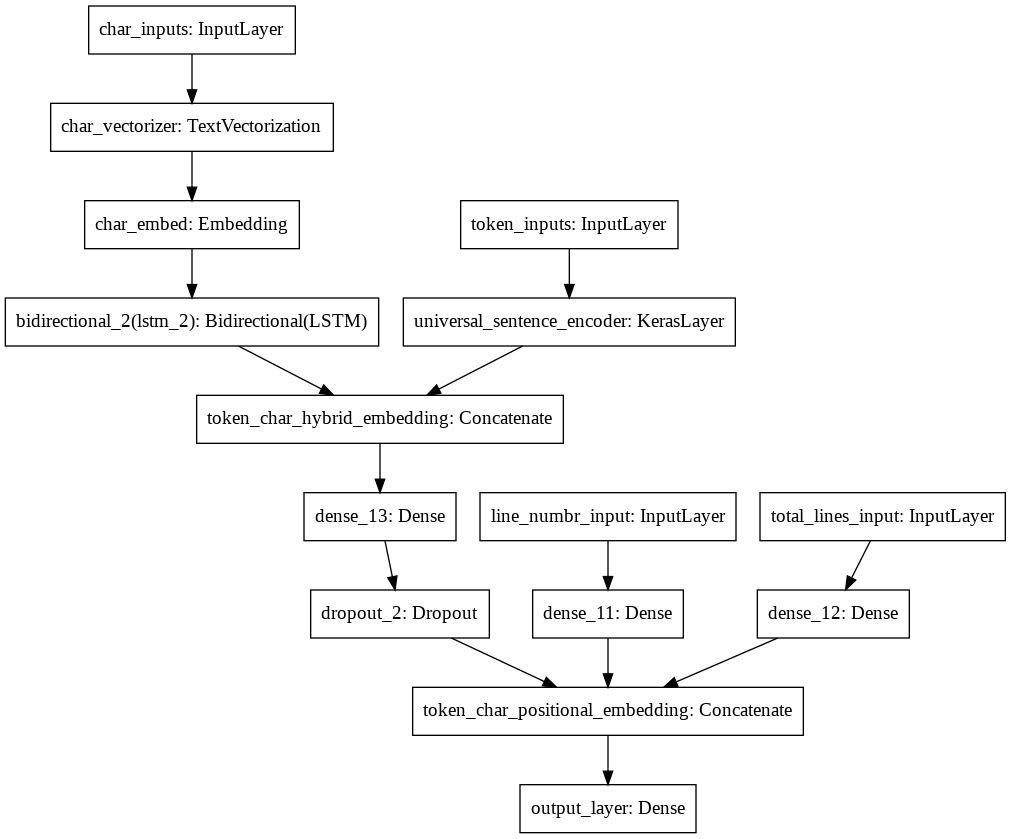

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_5)

In [ ]:
for layer in model_5.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f76ec481f50> True
<keras.layers.preprocessing.text_vectorization.TextVectorization object at 0x7f763c496050> True
<keras.engine.input_layer.InputLayer object at 0x7f763dff5850> True
<keras.layers.embeddings.Embedding object at 0x7f763c45dcd0> True
<tensorflow_hub.keras_layer.KerasLayer object at 0x7f76ee1ae690> False
<keras.layers.wrappers.Bidirectional object at 0x7f76fdb89890> True
<keras.layers.merge.Concatenate object at 0x7f774f6a5cd0> True
<keras.engine.input_layer.InputLayer object at 0x7f76fdda9710> True
<keras.engine.input_layer.InputLayer object at 0x7f76fdd31dd0> True
<keras.layers.core.Dense object at 0x7f76fdd31350> True
<keras.layers.core.Dense object at 0x7f76fdd4f190> True
<keras.layers.core.Dense object at 0x7f76fdd31d50> True
<keras.layers.core.Dropout object at 0x7f76fdd314d0> True
<keras.layers.merge.Concatenate object at 0x7f763c47e4d0> True
<keras.layers.core.Dense object at 0x7f763c4eff10> True


In [ ]:
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer = tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, # line numbers
                                                                train_total_lins_one_hot, # total lines
                                                                train_sentences, # train tokens
                                                                train_chars)) # train chars
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # train labels
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) # combine data and labels
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Check input shapes
train_pos_char_token_dataset, val_pos_char_token_dataset

(<PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>)

In [ ]:
history_model_5 = model_5.fit(train_pos_char_token_dataset,
                              steps_per_epoch=len(train_pos_char_token_dataset),
                              epochs=3,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps= len(val_pos_char_token_dataset))

Epoch 1/3
5627/5627 [==============================] - 156s 27ms/step - loss: 0.9640 - accuracy: 0.8195 - val_loss: 0.9176 - val_accuracy: 0.8470
Epoch 2/3
5627/5627 [==============================] - 152s 27ms/step - loss: 0.9256 - accuracy: 0.8476 - val_loss: 0.9075 - val_accuracy: 0.8547
Epoch 3/3
5627/5627 [==============================] - 152s 27ms/step - loss: 0.9165 - accuracy: 0.8545 - val_loss: 0.9019 - val_accuracy: 0.8595


In [ ]:
model_5_pred_probs = model_5.predict(val_pos_char_token_dataset, verbose=1)
model_5_pred_probs

945/945 [==============================] - 15s 15ms/step


array([[0.63098425, 0.11298028, 0.01372922, 0.22376244, 0.01854384],
       [0.58505577, 0.11636838, 0.05046501, 0.23996125, 0.00814959],
       [0.38855332, 0.09629423, 0.03944988, 0.4268865 , 0.04881607],
       ...,
       [0.02887809, 0.09629459, 0.02631557, 0.02757396, 0.82093775],
       [0.02279992, 0.31517985, 0.046958  , 0.02273759, 0.5923246 ],
       [0.0563815 , 0.8233408 , 0.06408939, 0.0277007 , 0.02848774]],
      dtype=float32)

In [ ]:
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [ ]:
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 85.94598172911427,
 'f1': 0.8566196788264042,
 'precision': 0.8609432352688492,
 'recall': 0.8594598172911426}

In [ ]:
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "custom_token_embed_conv1d": model_1_results,
                                  "pretrained_token_embed": model_2_results,
                                  "custom_char_embed_conv1d": model_3_results,
                                  "hybrid_char_token_embed": model_4_results,
                                  "tribrid_pos_char_token_embed": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,72.183238,0.718647,0.721832,0.698925
custom_token_embed_conv1d,80.699722,0.804535,0.806997,0.804462
pretrained_token_embed,76.767510,0.765761,0.767675,0.763692
custom_char_embed_conv1d,55.855289,0.529265,0.558553,0.527756
hybrid_char_token_embed,77.684364,0.775719,0.776844,0.772269
tribrid_pos_char_token_embed,85.945982,0.860943,0.859460,0.856620


In [ ]:
all_model_results["accuracy"] = all_model_results["accuracy"]/100

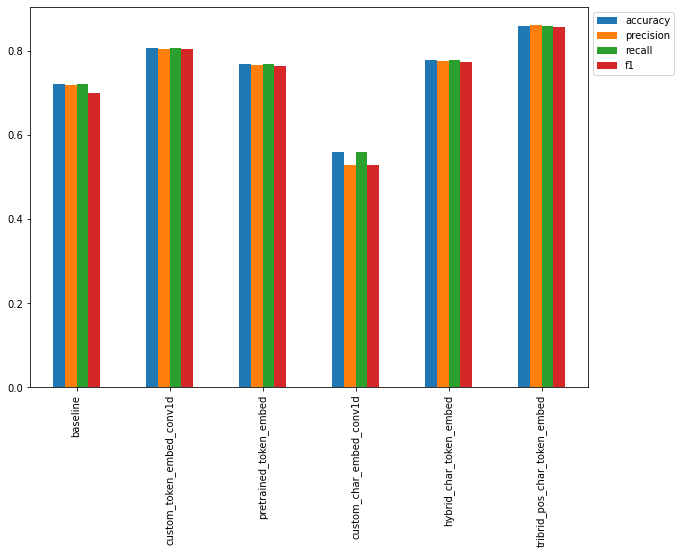

In [ ]:
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0))

In [ ]:
model_5.save("skimlit_tribrid_model")

INFO:tensorflow:Assets written to: skimlit_tribrid_model/assets


INFO:tensorflow:Assets written to: skimlit_tribrid_model/assets


In [ ]:
model_5.inputs

[<KerasTensor: shape=(None, 15) dtype=int32 (created by layer 'line_numbr_input')>,
 <KerasTensor: shape=(None, 20) dtype=int32 (created by layer 'total_lines_input')>,
 <KerasTensor: shape=(None,) dtype=string (created by layer 'token_inputs')>,
 <KerasTensor: shape=(None, 1) dtype=string (created by layer 'char_inputs')>]

In [ ]:
model_5.outputs

[<KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'output_layer')>]

In [ ]:
model_5.layers

In [ ]:
model_5_json_string = model_5.to_json()

In [ ]:
model_5_json_string

'{"class_name": "Functional", "config": {"name": "model_12", "layers": [{"class_name": "InputLayer", "config": {"batch_input_shape": [null, 1], "dtype": "string", "sparse": false, "ragged": false, "name": "char_inputs"}, "name": "char_inputs", "inbound_nodes": []}, {"class_name": "TextVectorization", "config": {"name": "char_vectorizer", "trainable": true, "batch_input_shape": [null], "dtype": "string", "max_tokens": 70, "standardize": "lower_and_strip_punctuation", "split": "whitespace", "ngrams": null, "output_mode": "int", "output_sequence_length": 290, "pad_to_max_tokens": false}, "name": "char_vectorizer", "inbound_nodes": [[["char_inputs", 0, 0, {}]]]}, {"class_name": "InputLayer", "config": {"batch_input_shape": [null], "dtype": "string", "sparse": false, "ragged": false, "name": "token_inputs"}, "name": "token_inputs", "inbound_nodes": []}, {"class_name": "Embedding", "config": {"name": "char_embed", "trainable": true, "batch_input_shape": [null, null], "dtype": "float32", "inp